# Summary

Our neighborhood is in a suburb of Houston that is just off of a major highway that many people use for commuting. It's a convenient place to either commute North into Houston or South to Lake Jackson. One reason we picked our house was its close proximity to the highway - I can be on the highway headed to work in about 5 minutes. But I've noticed it sometimes takes me 10 minutes just to go from my house to another house in the same community. So folks in other neighborhoods likely take significantly longer to get to and from the highway. The goal of the exercise below was to quantify the commuter convenience of my house.

The map below shows the average time for each neighborhood to get to and from the highway during commuting hours when commuting northbound to Houston. 

In [61]:
m_nb

The map below shows the average time for each neighborhood to get to and from the highway during commuting hours when commuting southbound to Lake Jackson. This is the direction I commute. 

In [62]:
m_sb

As demonstrated above, my neighborhood is one of the best with respect to commute times. From my neighborhood it takes roughly 6 minutes to get to the highway in the morning and 6 minutes to get to my house from the highway in the afternoon - a combined 12 minutes per day. Many neighborhoods are twice that! 

Extrapolating those numbers to a whole year means if I commute 5 days a week x 50 weeks a year, I'm in my car for 2 days worth of time per year just going to and from the highway. Some of the neighborhoods west of me spend 4 days per year in their car just getting to and from the highway. 

# Details on generating drive time maps...

In [1]:
import pandas as pd
import requests
import pickle
import os.path
import json
import time
from tqdm import tqdm
import numpy as np
import seaborn as sns

## Import spreadsheet and format addresses

In [2]:
# Pulled a list of addresses for my community from county tax website
cols_of_interest = ['prop_id','hood_cd','market', 'school','city', 'county',
    'legal_desc','tract_or_lot', 'abs_subdv_cd',
    'situs_num','situs_street', 'situs_street_sufix','situs_city', 'situs_state', 'situs_zip',
    'addr_line1', 'addr_line2','addr_line3', 'addr_city', 'addr_state', 'zip']

adds_df = pd.read_excel('address_list.xlsx')
adds_df = adds_df[cols_of_interest]
adds_df.head(2)

,prop_id,hood_cd,market,school,city,county,legal_desc,tract_or_lot,abs_subdv_cd,situs_num,...,situs_street_sufix,situs_city,situs_state,situs_zip,addr_line1,addr_line2,addr_line3,addr_city,addr_state,zip
0,539398,SF5,662280,SAL,CPL,GBC,SHADOW CREEK RANCH SF-5 (PEARLAND) BLK 1 LOT 1,1,S7502-5,2204,...,ST,PEARLAND,TX,77584.0,NaN,2204 HOLLOW SHORE ST,NaN,PEARLAND,TX,77584.0
1,539400,SF5,721270,SAL,CPL,GBC,SHADOW CREEK RANCH SF-5 (PEARLAND) BLK 1 LOT 2,2,S7502-5,2202,...,ST,PEARLAND,TX,77584.0,NaN,2202 HOLLOW SHORE ST,NaN,PEARLAND,TX,77584.0


In [3]:
# Clean up all of the columns that contain property address data
# ['situs_num', 'situs_street', 'situs_street_sufix', 'situs_city', 'situs_state', 'situs_zip']

adds_df['situs_num'] = adds_df['situs_num'].fillna(0)
adds_df['situs_street'] = adds_df['situs_street'].fillna('')
adds_df['situs_street_sufix'] = adds_df['situs_street_sufix'].fillna('')
adds_df['situs_city'] = adds_df['situs_city'].fillna('Pearland')
adds_df['situs_state'] = adds_df['situs_state'].fillna('TX')
adds_df['situs_zip'] = adds_df['situs_zip'].fillna('77584')

adds_df['situs_num'] = adds_df['situs_num'].apply(lambda x: str(int(x)))
adds_df['situs_street'] = adds_df['situs_street'].apply(lambda x: str(x).strip())
adds_df['situs_street_sufix'] = adds_df['situs_street_sufix'].apply(lambda x: str(x).strip())
adds_df['situs_city'] = adds_df['situs_city'].apply(lambda x: str(x).strip())
adds_df['situs_state'] = adds_df['situs_state'].apply(lambda x: str(x).strip())
adds_df['situs_zip'] = adds_df['situs_zip'].apply(lambda x: str(int(x)))

In [4]:
# Create new columns to construct full address which will be used in Bing Maps searches
adds_df.insert(0,'house_address_partial','',allow_duplicates=False)
adds_df.insert(0,'house_address','',allow_duplicates=False)
adds_df.head(2)

,house_address,house_address_partial,prop_id,hood_cd,market,school,city,county,legal_desc,tract_or_lot,...,situs_street_sufix,situs_city,situs_state,situs_zip,addr_line1,addr_line2,addr_line3,addr_city,addr_state,zip
0,,,539398,SF5,662280,SAL,CPL,GBC,SHADOW CREEK RANCH SF-5 (PEARLAND) BLK 1 LOT 1,1,...,ST,PEARLAND,TX,77584,NaN,2204 HOLLOW SHORE ST,NaN,PEARLAND,TX,77584.0
1,,,539400,SF5,721270,SAL,CPL,GBC,SHADOW CREEK RANCH SF-5 (PEARLAND) BLK 1 LOT 2,2,...,ST,PEARLAND,TX,77584,NaN,2202 HOLLOW SHORE ST,NaN,PEARLAND,TX,77584.0


In [5]:
# populate new columns for creating full address
adds_df['house_address_partial'] = adds_df['situs_num'] + ' ' + adds_df['situs_street'] + ' ' + adds_df['situs_street_sufix']
adds_df['house_address'] = adds_df['house_address_partial'] + ', ' + adds_df['situs_city'] + ', ' + adds_df['situs_state'] + ' ' + adds_df['situs_zip']

In [6]:
adds_df['prop_id'] = adds_df['prop_id'].apply(lambda x: int(x))
adds_df = adds_df.set_index('prop_id')
adds_df.head(2)

,house_address,house_address_partial,hood_cd,market,school,city,county,legal_desc,tract_or_lot,abs_subdv_cd,...,situs_street_sufix,situs_city,situs_state,situs_zip,addr_line1,addr_line2,addr_line3,addr_city,addr_state,zip
prop_id,,,,,,,,,,,,,,,,,,,,,
539398,"2204 HOLLOW SHORE ST, PEARLAND, TX 77584",2204 HOLLOW SHORE ST,SF5,662280,SAL,CPL,GBC,SHADOW CREEK RANCH SF-5 (PEARLAND) BLK 1 LOT 1,1,S7502-5,...,ST,PEARLAND,TX,77584,NaN,2204 HOLLOW SHORE ST,NaN,PEARLAND,TX,77584.0
539400,"2202 HOLLOW SHORE ST, PEARLAND, TX 77584",2202 HOLLOW SHORE ST,SF5,721270,SAL,CPL,GBC,SHADOW CREEK RANCH SF-5 (PEARLAND) BLK 1 LOT 2,2,S7502-5,...,ST,PEARLAND,TX,77584,NaN,2202 HOLLOW SHORE ST,NaN,PEARLAND,TX,77584.0


## Query Bing Maps API

In [7]:
testPropid = adds_df.index[0]
testAddress = adds_df['house_address'].iloc[0]
print([testPropid,testAddress])

[539398, '2204 HOLLOW SHORE ST, PEARLAND, TX 77584']


In [68]:
with open('secrets.pickle','rb') as f:
    secrets = pickle.load(f)

In [8]:
# Route payloads contains details for 4 different navigational routes: 
# 1) morning Northbound (AM-N) and 2) its afternoon counterpart (PM-N)
# 3) morning Southbound (AM-S) and 4) its afternoon counterpart (PM-S)
# I had to make afternoon times as arrival or else api didn't successfully respond
route_payloads = {
    'AM-N':{'wp.1':'29.595583, -95.386315','dateTime':'11/08/2023 08:00:00','timeType':'Departure'},
    'PM-N':{'wp.0':'29.594770, -95.386830','dateTime':'11/08/2023 17:30:00','timeType':'Arrival'},
    'AM-S':{'wp.1':'29.549921, -95.387785','dateTime':'11/08/2023 08:00:00','timeType':'Departure'},
    'PM-S':{'wp.0':'29.543948, -95.387128','dateTime':'11/08/2023 17:30:00','timeType':'Arrival'}
}

def bing_maps_query(house_address,route_payload):
    my_api_key = secrets['api_key']
    bing_map_url = r'http://dev.virtualearth.net/REST/V1/Routes/Driving'
    payload = {
        'avoid': 'tolls',
        'key': my_api_key,
        'distanceUnit': 'mi', 
        'travelMode': 'Driving',
        'optimize': 'timeWithTraffic' 
    }
    payload = payload|route_payload

    if 'wp.0' in payload.keys():
        payload['wp.1'] = house_address
    else:
        payload['wp.0'] = house_address

    r = requests.get('http://dev.virtualearth.net/REST/V1/Routes/Driving', params=payload)
    return r

# Some poor man's unit tests
# testResponse = bing_maps_query(testAddress,route_payloads['AM-S'])
# print(testResponse)

# test_responses = {i:bing_maps_query(testAddress,route_payloads[i]) for i in route_payloads}
# {i:test_responses[i].json()['resourceSets'][0]['resources'][0]['travelDuration'] for i in test_responses}

In [10]:
def format_response_filepath(propid,descriptor):
    subfolder = 'query_responses'
    response_filename =  str(propid) + '|' + descriptor  + '.pickle'
    response_path = os.path.join(subfolder,response_filename)
    return response_path
format_response_filepath(testPropid,'AM-N')

'query_responses/539398|AM-N.pickle'

## Loop through the addresses

In [11]:
# get routes for all addresses 
propid_subset = list(adds_df.index)

In [12]:
# add columns for route drive distances and times
new_col_initialVals = {'travelDistance':0.0,'distanceUnit':'','travelDuration':0,'travelDurationTraffic':0,'durationUnit':''}
new_columns = {'|'.join([route,col]):new_col_initialVals[col] for col in new_col_initialVals for route in route_payloads}
for col in new_columns:
    adds_df.insert(1,col,new_columns[col],allow_duplicates=False)

# add columns for address latitude/longitude
adds_df.insert(1,'lon',0.0,allow_duplicates=False)
adds_df.insert(1,'lat',0.0,allow_duplicates=False)

adds_df.head(2)

,house_address,lat,lon,PM-S|durationUnit,AM-S|durationUnit,PM-N|durationUnit,AM-N|durationUnit,PM-S|travelDurationTraffic,AM-S|travelDurationTraffic,PM-N|travelDurationTraffic,...,situs_street_sufix,situs_city,situs_state,situs_zip,addr_line1,addr_line2,addr_line3,addr_city,addr_state,zip
prop_id,,,,,,,,,,,,,,,,,,,,,
539398,"2204 HOLLOW SHORE ST, PEARLAND, TX 77584",0.0,0.0,,,,,0,0,0,...,ST,PEARLAND,TX,77584,NaN,2204 HOLLOW SHORE ST,NaN,PEARLAND,TX,77584.0
539400,"2202 HOLLOW SHORE ST, PEARLAND, TX 77584",0.0,0.0,,,,,0,0,0,...,ST,PEARLAND,TX,77584,NaN,2202 HOLLOW SHORE ST,NaN,PEARLAND,TX,77584.0


In [13]:
# loop through property ID / addresses. 
# Check if we've already saved the route info, otherwise query maps API and save the response
for propid in tqdm(propid_subset):
    prop_address = adds_df.loc[propid]['house_address']
    for route in route_payloads:
        prop_route_filepath = format_response_filepath(propid,route)
        if os.path.isfile(prop_route_filepath):
            with open(prop_route_filepath,'rb') as f:
                r = pickle.load(f)
        else:
            r = bing_maps_query(prop_address,route_payloads[route])
            with open(prop_route_filepath,'wb') as f:
                pickle.dump(r,f)
        # Extract some data from good responses
        if r.json()['statusCode'] == 200:
            route_data = r.json()['resourceSets'][0]['resources'][0]
            result_keys = {
                'travelDistance':float,
                'distanceUnit':str,
                'travelDuration':int,
                'travelDurationTraffic':int,
                'durationUnit':str
                }
            # get results of interest, cast into proper data types, insert into df
            results = {key:result_keys[key](route_data[key]) for key in result_keys}
            new_columns = ['|'.join([route,key]) for key in result_keys]
            adds_df.loc[propid,new_columns] = [results[key] for key in results]
            # get latitude/longitude
            if route.startswith('AM'):
                adds_df.loc[propid,['lat','lon']] = route_data['routeLegs'][0]['startLocation']['point']['coordinates']

  0%|          | 0/4578 [00:00<?, ?it/s]

100%|██████████| 4578/4578 [00:13<00:00, 333.82it/s]


## Histograms of time to get to/from highway

### Northbound commutes

/Users/nick/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nick/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Combined-N|travelDurationTraffic', ylabel='Probability'>

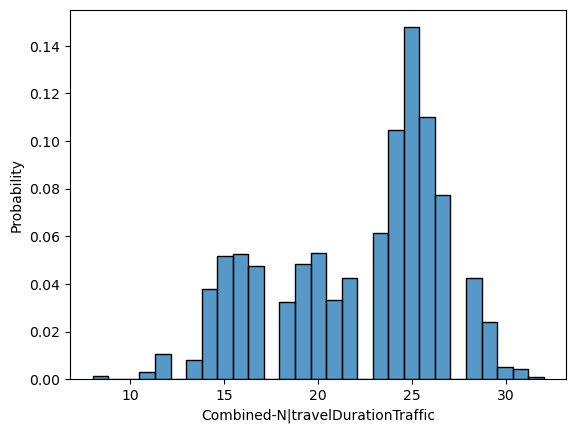

In [69]:
adds_df['Combined-N|travelDurationTraffic'] = np.round((adds_df['AM-N|travelDurationTraffic']+adds_df['PM-N|travelDurationTraffic'])/60)
temp_route = 'Combined-N|travelDurationTraffic'
sns.histplot(data=adds_df[adds_df[temp_route]>1],x=temp_route,stat='probability')

### Southbound commutes

/Users/nick/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nick/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Combined-S|travelDurationTraffic', ylabel='Probability'>

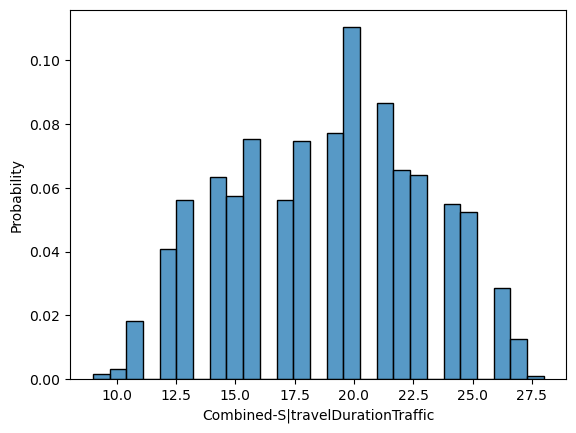

In [70]:
adds_df['Combined-S|travelDurationTraffic'] = np.round((adds_df['AM-S|travelDurationTraffic']+adds_df['PM-S|travelDurationTraffic'])/60)
temp_route = 'Combined-S|travelDurationTraffic'
sns.histplot(data=adds_df[adds_df[temp_route]>1],x=temp_route,stat='probability')

Note: kind of odd that the above histogram has gaps in it. Likely due to entire neighborhoods falling into one or two bins

## Folium maps

In [71]:
from shapely.geometry import MultiPoint
import folium
import geopandas as gpd

In [72]:
# filter out some unintentional properties on south 
adds_df_subset = adds_df[adds_df['lat'] > 29.5550]
adds_df_subset.head(2)

,house_address,lat,lon,PM-S|durationUnit,AM-S|durationUnit,PM-N|durationUnit,AM-N|durationUnit,PM-S|travelDurationTraffic,AM-S|travelDurationTraffic,PM-N|travelDurationTraffic,...,situs_state,situs_zip,addr_line1,addr_line2,addr_line3,addr_city,addr_state,zip,Combined-N|travelDurationTraffic,Combined-S|travelDurationTraffic
prop_id,,,,,,,,,,,,,,,,,,,,,
539398,"2204 HOLLOW SHORE ST, PEARLAND, TX 77584",29.571116,-95.400178,Second,Second,Second,Second,517,331,397,...,TX,77584,NaN,2204 HOLLOW SHORE ST,NaN,PEARLAND,TX,77584.0,17.0,14.0
539400,"2202 HOLLOW SHORE ST, PEARLAND, TX 77584",29.571330,-95.400268,Second,Second,Second,Second,492,340,403,...,TX,77584,NaN,2202 HOLLOW SHORE ST,NaN,PEARLAND,TX,77584.0,17.0,14.0


In [73]:
avg_hood_df = adds_df_subset[['hood_cd','Combined-N|travelDurationTraffic','Combined-S|travelDurationTraffic','market']].groupby('hood_cd').mean().copy().reset_index(drop=False)
avg_hood_df.head(2)

,hood_cd,Combined-N|travelDurationTraffic,Combined-S|travelDurationTraffic,market
0,S7512,25.383929,20.276786,471674.160714
1,SF1,18.837209,17.139535,385578.860465


In [74]:
hoods_geometry = [MultiPoint(adds_df_subset[adds_df_subset['hood_cd']==hood][['lon','lat']].to_numpy()) for hood in avg_hood_df['hood_cd']]
hoods_gpd = gpd.GeoDataFrame(avg_hood_df,geometry=hoods_geometry,crs='EPSG:4326')
hoods_gpd['geometry'] = hoods_gpd['geometry'].concave_hull(ratio=0.25)
hoods_gpd.head(2)

,hood_cd,Combined-N|travelDurationTraffic,Combined-S|travelDurationTraffic,market,geometry
0,S7512,25.383929,20.276786,471674.160714,"POLYGON ((-95.43033 29.55656, -95.43032 29.557..."
1,SF1,18.837209,17.139535,385578.860465,"POLYGON ((-95.40639 29.57380, -95.40639 29.574..."


In [75]:
m_nb = folium.Map(
    location=(29.568913, -95.412054),
    min_zoom=14,
    zoom_start=15,
    max_zoom=17,
    # width="50%",
    # height="50%",
)

folium.Marker(
    location=[29.562233, -95.397377],
    # tooltip="Click me!",
    # popup="Mt. Hood Meadows",
    icon=folium.Icon(icon="home"),
).add_to(m_nb)

folium.Choropleth(
    geo_data=hoods_gpd,
    data=hoods_gpd,
    name="choropleth",
    columns=["hood_cd", "Combined-N|travelDurationTraffic"],
    key_on="feature.properties.hood_cd",
    fill_color="OrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Northbound - Daily travel time to/from highway (minutes)",
).add_to(m_nb)

m_nb

In [76]:
m_sb = folium.Map(
    location=(29.568913, -95.412054),
    min_zoom=14,
    zoom_start=15,
    max_zoom=17,
    # width="50%",
    # height="50%",
)

folium.Marker(
    location=[29.562233, -95.397377],
    # tooltip="Click me!",
    # popup="Mt. Hood Meadows",
    icon=folium.Icon(icon="home"),
).add_to(m_sb)

folium.Choropleth(
    geo_data=hoods_gpd,
    data=hoods_gpd,
    name="choropleth",
    columns=["hood_cd", "Combined-S|travelDurationTraffic"],
    key_on="feature.properties.hood_cd",
    fill_color="OrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Soutbound - Daily travel time to/from highway (minutes)",
).add_to(m_sb)

m_sb